In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.utils import np_utils

from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score
)
from sklearn.model_selection import (
    train_test_split as tts,
    StratifiedKFold)
from sklearn.utils.multiclass import type_of_target

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [51]:
def get_kmers(sequences, kmer=4):
    return_seqs = sequences.copy()
    if kmer <= 1:
        raise ValueError("kmer size must be greater than 1")
    for seq_index, seq in sequences.iteritems():
        kmer_list = []
        for let_index, let in enumerate(seq[:-kmer + 1]):
            kmer_list.append(seq[let_index:let_index + kmer])
        return_seqs[seq_index] = kmer_list
    return return_seqs

def get_2d_kmer(seqs, mnm, mxm):
    return_seqs = []
    for _, val in seqs.iteritems():
        kmer_seqs = []
        for i in range(mnm, mxm+1):
            kmers = list(get_kmers(pd.Series([val]), kmer=i))[0]
            # kmers += [kmers[-1] for _ in range(i-1)]
            kmer_seqs.append(kmers)
        return_seqs.append(kmer_seqs)
    
    return pd.Series(return_seqs)

def dup_vecs(dfs):
    dup_X_2d = []
    for df_ind, df in enumerate(dfs):
        num_dupes = 4**(2-df_ind)
        print(num_dupes)
        new_df = df.values.tolist()
        for ind, seq in enumerate(new_df):
            new_seq = []
            for num in seq:
                for i in range(num_dupes):
                    new_seq.append(num)
            new_df[ind] = new_seq
        dup_X_2d.append(pd.DataFrame(new_df))

    return dup_X_2d

def tfidf_vectorize(tfidf, series):
    new_series = []
    for ind, _ in enumerate(series[0]):
        new_series.append([series[i][ind] for i, _ in series.iteritems()])

    new_series = pd.Series(new_series)
    # return new_series

    new_dfs = []
    for ind, val in new_series.iteritems():
        new_dfs.append(pd.DataFrame(tfidf.fit_transform(
            [' '.join(v) for _, v in pd.Series(val).iteritems()]
        ).toarray()))
    
    return new_dfs

def get_dup_X_2d(X):
    X_2d = get_2d_kmer(X, 4, 6)
    tfidf = TfidfVectorizer()
    vectorized_2d = tfidf_vectorize(tfidf, X_2d)
    dup_X_2d = dup_vecs(vectorized_2d)
    dup_X_2d = [i.values.tolist() for i in dup_X_2d]
    dup_X_2d = np.array([[dup_X_2d[i][ind] for i in range(len(dup_X_2d))] for ind in range(len(dup_X_2d[0]))])
    dup_X_2d = dup_X_2d.reshape(*dup_X_2d.shape, 1).astype('float32')
    return dup_X_2d

def get_X_1d(X):
    X_1d = get_kmers(X, kmer=3)
    tfidf = TfidfVectorizer()
    X_1d = pd.DataFrame(
        tfidf.fit_transform(
            [' '.join(val) for index, val in X_1d.iteritems()]
        ).toarray())
    print(X_1d.shape)
    X_1d = np.asarray(X_1d).reshape(*(X_1d.shape), 1).astype('float32')


opt = keras.optimizers.Adam(learning_rate=0.0005)

def DCNNv2(num_features, num_classes):
    model = keras.Sequential()
    # model.add(layers.Dropout(0.1, input_shape=(num_features, 1)))
    model.add(layers.Conv1D(100, 3, activation='softsign', strides=2, input_shape=(num_features, 1)))
    model.add(layers.Conv1D(50, 3, activation='softsign', strides=2))
    model.add(layers.Conv1D(32, 3, activation='softsign', strides=2))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softsign'))
    model.add(layers.Dropout(0.1))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(24, activation='softsign'))
    model.add(layers.Dropout(0.2))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='softsign'))
    model.add(layers.Dropout(0.3))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='softsign'))
    model.add(layers.Dropout(0.4))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model



def DCNNv1(num_features, num_classes):
    model = keras.Sequential()
    model.add(layers.Dropout(0.1, input_shape=(num_features, 1)))
    model.add(layers.Conv1D(32, 5, activation='softsign', input_shape=(num_features, 1)))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softsign'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def DCNNv3(num_features, num_classes, num_kmers):
    model = keras.Sequential()
    model.add(layers.Dropout(0.1, input_shape=(num_kmers, num_features, 1)))
    model.add(layers.Conv2D(32, (2, 3), activation='softsign', input_shape=(num_kmers, num_features, 1)))
    model.add(layers.Dropout(0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softsign'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def DCNNv4(num_features, num_classes, num_kmers):
    inputs = []

In [3]:
data = pd.read_csv('../data/pro_nonpro.csv')
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
X = data.Seq
y = data.Level

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))

In [7]:
# there are 4 letters, the vocabulary roughly follows powers of four because those are the possible combinations of length kmer

In [39]:
def categorical_X_1d(X):
    X_kmers = get_2d_kmer(X, mnm=3, mxm=6)
    tfidf = TfidfVectorizer()
    vectorized_2d = tfidf_vectorize(tfidf, X_kmers)
    new_df = []
    for seq_ind in range(len(vectorized_2d[0])):
        new_row = []
        for vec_ind in range(len(vectorized_2d)):
            new_row += list(vectorized_2d[vec_ind].iloc[seq_ind,:])
        
        new_df.append(new_row)
    
    new_df = pd.DataFrame(new_df)

    new_df = np.asarray(new_df).reshape(*new_df.shape, 1).astype('float32')
    return new_df


In [40]:
categ_X = categorical_X_1d(X)

In [47]:
num_features = 5440
num_classes = 2
num_epochs = 50

In [16]:
# X_1d = np.asarray(X_1d).reshape(len(X_1d), num_features, 1).astype('float32')

In [19]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [6]:
X_2d = get_dup_X_2d(X)

16
4
1


In [44]:
X_train, X_test, y_train, y_test = tts(categ_X, y, train_size=0.7)
y_train = np_utils.to_categorical(y_train, num_classes)
y_test_keras = np_utils.to_categorical(y_test, num_classes)

In [21]:
for i in range(15):
    display(model.layers[i].get_output_shape_at(0))

NameError: name 'model' is not defined

In [52]:
# for train, test in kfold.split(X, y):

model = DCNNv1(num_features, num_classes)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test_keras),
    epochs=num_epochs,
    batch_size=128,
    verbose=True,
)


Epoch 1/50
37/37 [==============================] - 1s 26ms/step - loss: 0.5374 - accuracy: 0.7771 - val_loss: 0.5454 - val_accuracy: 0.7970
Epoch 2/50
37/37 [==============================] - 1s 22ms/step - loss: 0.3792 - accuracy: 0.8428 - val_loss: 0.5218 - val_accuracy: 0.8094
Epoch 3/50
37/37 [==============================] - 1s 22ms/step - loss: 0.3395 - accuracy: 0.8663 - val_loss: 0.4992 - val_accuracy: 0.8094
Epoch 4/50
37/37 [==============================] - 1s 22ms/step - loss: 0.3081 - accuracy: 0.8817 - val_loss: 0.4781 - val_accuracy: 0.8153
Epoch 5/50
37/37 [==============================] - 1s 22ms/step - loss: 0.2789 - accuracy: 0.8927 - val_loss: 0.4580 - val_accuracy: 0.8113
Epoch 6/50
37/37 [==============================] - 1s 22ms/step - loss: 0.2448 - accuracy: 0.9066 - val_loss: 0.4442 - val_accuracy: 0.8133
Epoch 7/50
37/37 [==============================] - 1s 22ms/step - loss: 0.2168 - accuracy: 0.9210 - val_loss: 0.4360 - val_accuracy: 0.8128
Epoch 8/50
37

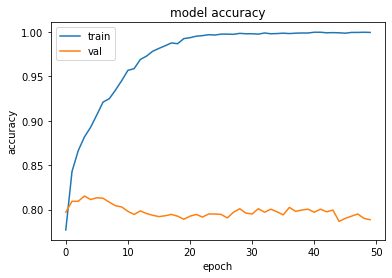

In [53]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

64/64 [==============================] - 0s 5ms/step
CV: 


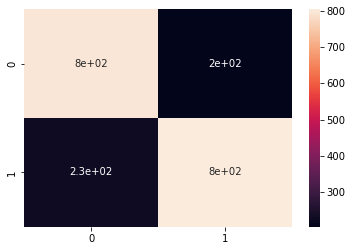

In [54]:
predictions = model.predict(
    X_test)
predictions = np.argmax(predictions, axis=1)
true_labels = np.asarray(y_test)
print('CV: ')
sns.heatmap(pd.DataFrame(confusion_matrix(true_labels, predictions), range(num_classes), range(num_classes)), annot=True)
plt.show()


In [ ]:
# train = test: make model bigger/dense
# increase batch size
# train > test: decrease complexity, add dropout, normalization
# use stride-2 conv layers instead of maxpooling
# increase filter size
# possibly add dense layers first
# possibly add conv1d
# add more gradual dense layers (dropouts in between)
# add batch normalisation

In [6]:
Sequence = 'CATGCTGACTAGCTG'
BinaryEncoding = 110001101101100011010010110110


In [12]:
pd.DataFrame([['Binary Encoding', BinaryEncoding], ['Sequence', Sequence]], columns=['', ''])

,,
0,Binary Encoding,1100011011011000110100101101100110011110000110...
1,Sequence,CATGCTGACTAGCTG


In [7]:
maps = {
    'A': '00',
    'T': '01',
    'G': '10',
    'C': '11'
}

print(''.join([maps[i] for i in Sequence]))

110001101101100011010010110110
